# The London Undergroung Graphical Network

In this section of the project, we'll be representing the London Tube rail network as a graph. And we think utilizing NetworkX will be the esiest way to achieve this. Nodes will be the stations and edges are the connections between them. We will make some analyses our graphs such as pageranking, calculating Hits, degree of centralities and inbetweeness etc. 

So first, we'll start with the imports. 

In [1]:
%matplotlib inline

import colorsys 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
output_notebook( resources=CDN )

pd.set_option('max_colwidth', 200) 

Loading BokehJS ...

Because we found out that the data from TfL are complicated, incomplete, or unavilable, we decided to use the London Tube line data from Wikipedia. It has more attributes like line type, length, etc which will be useful during our analyses. 

In [2]:
tabs = pd.read_html("https://en.wikipedia.org/wiki/London_Underground_infrastructure", flavor = 'bs4', match='Bakerloo line') 

len(tabs) 

1

In [3]:
tabs[0] # The table we need from Wikipedia 

,Name,Mapcolour[54],Firstoperated,Firstsectionopened*,Namedatesfrom,Type♯,Length(km),Length(miles),No.Sta,CurrentStock,FutureStock,Trips per annumin thousands[55],Avg. trips per mile(per kilometre)in thousands
0,Bakerloo line,Light Brown,1906,1906,1906,DT,23.2.0,14.5.0,25,1972 Stock,NTfL,111136,"7,665(4,763)"
1,Central line,Red,1900,1856,1900,DT,74.00,46.00,49,1992 Stock,NTfL,260916,"5,672(3,524)"
2,Circle line+,Yellow,1884,1863,1949,SS,27.2.0,17.00,36,S Stock,NaN,114609,"4,716(2,930)"
3,District line,Green,1868,1858,1868,SS,64.00,40.00,60,S Stock,NaN,208317,"5,208(3,236)"
4,Hammersmith & City line+,Pink,1988~,1858,1988,SS,25.5.0,15.9.0,29,S Stock,NaN,114609,"4,716(2,930)"
5,Jubilee line,Silver,1979,1879,1979,DT,36.2.0,22.5.0,27,1996 Stock,NaN,213554,"9,491(5,897)"
6,Metropolitan line,Dark Magenta,1863,1863,1863,SS,66.7.0,41.5.0,34,S Stock,NaN,66779,"1,609(1,000)"
7,Northern line,Black,1890,1867,1937,DT,58.00,36.00,52,1995 Stock,NaN,252310,"7,009(4,355)"
8,Piccadilly line,Dark Blue,1906,1869,1906,DT,71.00,44.3.0,53,1973 Stock,NTfL,210169,"4,744(2,948)"
9,Victoria line,Light Blue,1968,1968,1968,DT,21.00,13.250,16,2009 Stock,NaN,199988,"15,093(9,378)"


Reshaping the data from Wikipedia to make it easy for us to work with. 

In [4]:
df = tabs[0][:11] # Selecting only the needed items in the table, which in this case is the first 10 rows of the first table. 

new_df = pd.DataFrame() # Creating a new dataframe to make changes to the column names in the current dataframe. 

new_df['name'] = df['Name'].str.replace(' line', '', regex=True) # Removing uneccessary texts from our entries. 
new_df['name'] = new_df['name'].str.replace('+', '', regex=True) 
new_df['colour_on_map'] = df['Mapcolour[54]'] 
new_df['type'] = df['Type♯'].str.replace('DT', 'Deep Tube', regex=True) 
new_df['type'] = new_df['type'].str.replace('SS', 'Sub-surface', regex=True) 
new_df['first_operated'] = df['Firstoperated'].str.replace('†', '', regex=True) 
new_df['first_operated'] = new_df['first_operated'].str.replace('~', '', regex=True) 
new_df['length_in_miles'] = [float(i[:4]) for i in df['Length(miles)']] 
new_df['num_of_stations'] = df['No.Sta'].astype('int') 

new_df.index = new_df.index + 1 

new_df.to_csv('../Data/TfL-Station-Data-detailed/Transformed/Wiki/Lines.csv', index=True, index_label='id') 

new_df 

,name,colour_on_map,type,first_operated,length_in_miles,num_of_stations
1,Bakerloo,Light Brown,Deep Tube,1906,14.5,25
2,Central,Red,Deep Tube,1900,46.0,49
3,Circle,Yellow,Sub-surface,1884,17.0,36
4,District,Green,Sub-surface,1868,40.0,60
5,Hammersmith & City,Pink,Sub-surface,1988,15.9,29
6,Jubilee,Silver,Deep Tube,1979,22.5,27
7,Metropolitan,Dark Magenta,Sub-surface,1863,41.5,34
8,Northern,Black,Deep Tube,1890,36.0,52
9,Piccadilly,Dark Blue,Deep Tube,1906,44.3,53
10,Victoria,Light Blue,Deep Tube,1968,13.2,16


Loading all needed dataframes

In [5]:
lines = pd.read_csv('../Data/TfL-Station-Data-detailed/Transformed/Wiki/Lines.csv', index_col=0) 
stations = pd.read_csv('../Data/TfL-Station-Data-detailed/Transformed/Stations_Coodinates.csv', index_col=0) 
connections = pd.read_csv('../Data/TfL-Station-Data-detailed/Transformed/LU_Loading_Data.csv') 

In [6]:
lines.head(3)

,name,colour_on_map,type,first_operated,length_in_miles,num_of_stations
id,,,,,,
1,Bakerloo,Light Brown,Deep Tube,1906,14.5,25
2,Central,Red,Deep Tube,1900,46.0,49
3,Circle,Yellow,Sub-surface,1884,17.0,36


In [7]:
stations.head(3)

,unique_id,name,latitude,longitude,total_lines,fare_zones
id,,,,,,
1,940GZZLUACT,Acton Town,51.5028,-0.2801,2,3
2,940GZZLUALD,Aldgate,51.5143,-0.0755,2,1
3,940GZZLUADE,Aldgate East,51.5154,-0.0726,2,1


In [8]:
connections.head(3) 

,from_id,to_id,from_naptan,to_naptan,from_station,to_station,line_id,line,direction,line_direction,platform_direction
0,108,133,940GZZLUHAW,940GZZLUKEN,Harrow & Wealdstone,Kenton,1,Bakerloo,Inbound,SB,SB
1,133,221,940GZZLUKEN,940GZZLUSKT,Kenton,South Kenton,1,Bakerloo,Inbound,SB,SB
2,221,172,940GZZLUSKT,940GZZLUNWY,South Kenton,North Wembley,1,Bakerloo,Inbound,SB,SB


## A simplified graph

Now that we have our dataframes, we can create a simple graph of the network.

In [9]:
simple_graph = nx.Graph() 

simple_graph.add_nodes_from(stations['name']) 
simple_graph.add_edges_from(list(zip(connections['from_station'], connections['to_station']))) 

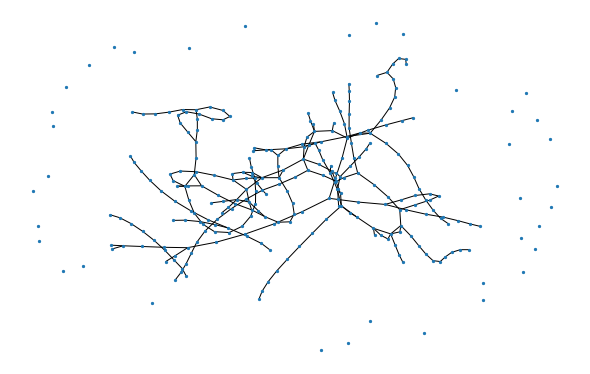

In [10]:
plt.figure(figsize =(8, 5)) 
nx.draw(simple_graph, node_size = 5) 

We can see from the above graph what the London Tube connections look like. Nodes which are ditached from the network are stations from the Stations_Coordinates.csv file that has no loading record in the LU_Loading_Data.csv file. \
Although this is not a realistic representation of the stations location compared to what they would look like on a geographical map. 

Already we can even do some analysing on the graph, like getting a reasonable (shortest) path between the stations `Oxford Circus` and `Canary Wharf`

In [11]:
nx.shortest_path(simple_graph, 'Oxford Circus', 'Canary Wharf') 

['Oxford Circus',
 'Green Park',
 'Westminster',
 'Waterloo',
 'Southwark',
 'London Bridge',
 'Bermondsey',
 'Canada Water',
 'Canary Wharf']

Also we can run the PageRank and Hits algorithm on the network to messure the connections between the LU stations. Both of these compares the nodes (LU stations) using the numbers of connections found between them. \
\
This time though, we'll focus on the stations that has connections between them as edges. 

In [12]:
graph = nx.Graph() 

graph.add_edges_from(list(zip(connections['from_station'], connections['to_station']))) 

In [13]:
pagerank = nx.pagerank_numpy(graph)
pagerank = pd.DataFrame(pagerank.items(), columns=['name', 'pagerank'])
stations = pd.merge(stations, pagerank, on='name') 

C:\Users\GTITEC~1\AppData\Local\Temp/ipykernel_14200/3355103146.py:1: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  pagerank = nx.pagerank_numpy(graph)


In [14]:
stations.sort_values('pagerank', ascending=False).head(10)

,unique_id,name,latitude,longitude,total_lines,fare_zones,pagerank
227,HUBWAT,Waterloo,51.5036,-0.1143,4,1,0.007748
9,940GZZLUBST,Baker Street,51.5226,-0.1571,5,1,0.007738
214,940GZZLUTNG,Turnham Green,51.4951,-0.2547,2,2|3,0.007454
60,940GZZLUECT,Earl's Court,51.4920,-0.1973,2,1|2,0.007004
230,940GZZLUWYP,Wembley Park,51.5635,-0.2795,2,4,0.006757
199,940GZZLUSKW,Stockwell,51.4723,-0.1230,2,2,0.006697
159,940GZZLUOXC,Oxford Circus,51.5150,-0.1415,3,1,0.006594
86,940GZZLUGPK,Green Park,51.5067,-0.1428,3,1,0.006591
102,940GZZLUHBN,Holborn,51.5174,-0.1200,2,1,0.006585
38,HUBCFO,Chalfont & Latimer,51.6679,-0.5610,1,8,0.006502


In [15]:
hits = nx.hits_scipy(graph, max_iter=1000)[0]
hits = pd.DataFrame(hits.items(), columns=['name', 'hits'])
stations = pd.merge(stations, hits, on='name') 

C:\Users\GTITEC~1\AppData\Local\Temp/ipykernel_14200/2670849592.py:1: DeprecationWarning: networkx.hits_scipy is deprecated and will be removedin NetworkX 3.0, use networkx.hits instead.
  hits = nx.hits_scipy(graph, max_iter=1000)[0]


In [16]:
stations.sort_values('hits', ascending=False).head(10)

,unique_id,name,latitude,longitude,total_lines,fare_zones,pagerank,hits
227,HUBWAT,Waterloo,51.5036,-0.1143,4,1,0.007748,0.061154
86,940GZZLUGPK,Green Park,51.5067,-0.1428,3,1,0.006591,0.054321
159,940GZZLUOXC,Oxford Circus,51.5150,-0.1415,3,1,0.006594,0.052288
239,HUBWSM,Westminster,51.5010,-0.1254,3,1,0.003985,0.046624
22,HUBBDS,Bond Street,51.5142,-0.1494,2,1,0.005527,0.044850
69,940GZZLUEMB,Embankment,51.5074,-0.1223,4,1,0.005504,0.041229
11,HUBBAN,Bank,51.5133,-0.0886,4,1,0.005423,0.041045
9,940GZZLUBST,Baker Street,51.5226,-0.1571,5,1,0.007738,0.029310
209,HUBTCR,Tottenham Court Road,51.5165,-0.1310,2,1,0.005667,0.029199
128,HUBLBG,London Bridge,51.5052,-0.0864,2,1,0.005688,0.026648


We show the top 10 station rank for both PageRank and Hits comparison above. Where PageRank finds the most important stations, the HITS algorithm seems to be pretty good at finding the busiest stations. To fully understand this, we can say the network relies on the important stations to function and without them, operations will be affected significantly. But the busiest stations does not impact the network operation in such significant way, they only tell us which stations has the highest traffic. 

Lets visualise the importance of stations as defined by PageRank. Less important stations will be colored green, and more important stations will be colored red. \
At the same time, we'll make use of the coordinates from our `stations` dataframe to allign the nodes in order to make our graph a more realistic plot of the London Underground stations. 

In [17]:
def pseudocolor(val):
    h = (1.0 - val) * 120 / 360
    r, g, b = colorsys.hsv_to_rgb(h, 1., 1.)
    return r * 255, g * 255, b * 255 

In [20]:
normed = stations[['longitude', 'latitude', 'pagerank']] 
normed = normed - normed.min() 
normed = normed / normed.max() 
locations = dict(zip(stations['name'], normed[['longitude', 'latitude']].values)) 
pageranks = dict(zip(stations['name'], normed['pagerank'].values)) 

p = figure(
    x_range = (.4,.7), 
    y_range = (.2,.5), 
    height= 600, 
    width=1000, 
)

for edge in graph.edges(): 
    try: 
        p.line( 
            x= [locations[pt][0] for pt in edge],
            y= [locations[pt][1] for pt in edge],
        )
    except KeyError:
        pass 

for node in graph.nodes():
    try: 
        x = [locations[node][0]]
        y = [locations[node][1]]
        p.circle( 
            x, y, 
            radius = .01 * pageranks[node], 
            fill_color = pseudocolor(pageranks[node]), 
            line_alpha=0) 
        p.text(
            x, y, 
            text = {'value':node}, 
            text_font_size = str(min(pageranks[node] * 12, 10)) + "pt", 
            text_alpha = pageranks[node],
            text_align='center',
            text_font_style='bold') 
    except KeyError:
        pass 
    
show(p) 

## Degree Centrality

## Edge Rank

## Using K-Means to obtain zones 

## Conclusion 